# Cross-validation tutorial for time series data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster, CrossValidator
import deep4cast.topologies as topologies

%matplotlib inline

Using TensorFlow backend.


In this tutorial, we show how to quickly set up and validate a regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting. In this example, we predict the next 24 hours of energy load based on the past 48 hours.

# Data preparation

In [2]:
# Load the data from file
filename = '../data/energy.csv'
df = pd.read_table(filename, sep=',')
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

# Prepare the data set
data = df[['load', 'temp']].values
data = np.expand_dims(data, axis=0) # We need the format (number of distinct time series, number of time steps, variables)

Unfortunately for us, temporal cross-validation is a little more involved than regular cross-validation. This is because of the temporal causality that may exist in the data set. This means that the future can depend on the past, but the past cannot depend on the future. This needs to be respected when model prediction accuracy is to be evaluated, because in a real-world prediction scenario we usually only have past data availabe to predict the future.

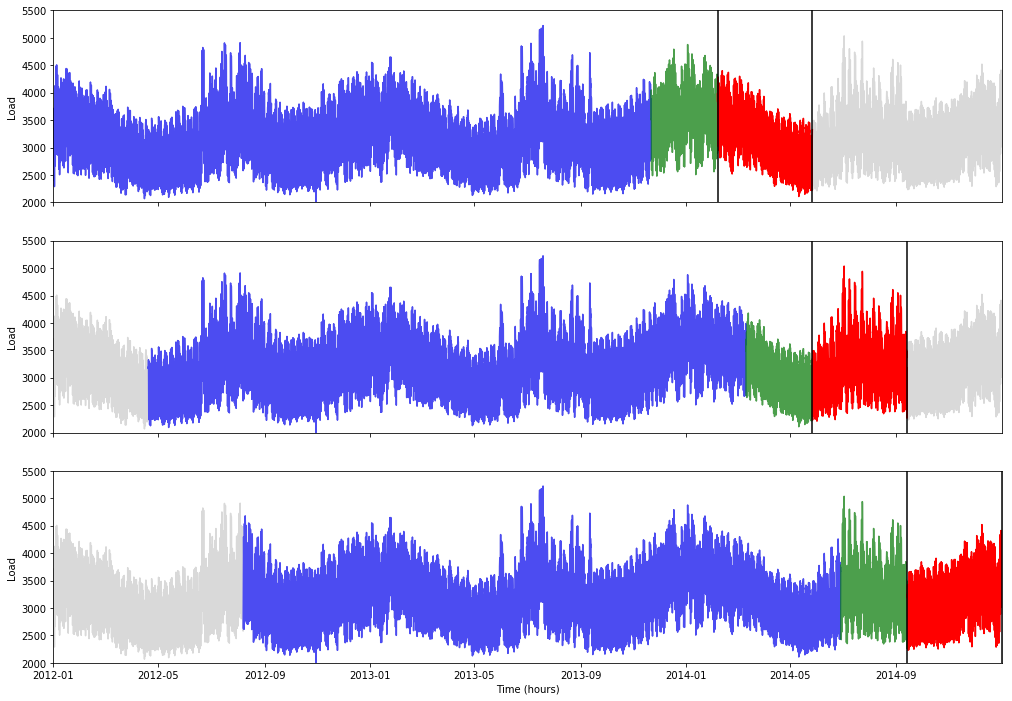

<Figure size 432x288 with 0 Axes>

In [14]:
# Let plot the target time series data folds that will be used for temporal cross-validation
n_folds = 3
test_fraction = 0.1
val_fraction = 0.1
test_length = int(len(df)*test_fraction)
train_length = len(df) - n_folds*test_length
val_length = int(train_length*val_fraction)
train_length = train_length - val_length

fig, axes = plt.subplots(nrows=n_folds, ncols=1, sharex=True, figsize=(17, 12))

for ax, i in zip(axes.flat, range(n_folds)):
    x_train = df.index[i*test_length:i*test_length+train_length]
    y_train = df.load[i*test_length:i*test_length+train_length]
    x_val = df.index[i*test_length+train_length:i*test_length+train_length+val_length]
    y_val = df.load[i*test_length+train_length:i*test_length+train_length+val_length]
    x_test = df.index[i*test_length+train_length+val_length:(i+1)*test_length+train_length+val_length]
    y_test = df.load[i*test_length+train_length+val_length:(i+1)*test_length+train_length+val_length]
    x_all = df.index
    y_all = df.load
    ax.plot(x_all, y_all, 'k-', alpha=0.15)
    ax.plot(x_train, y_train, 'b-', alpha=0.65)
    ax.plot(x_val, y_val, 'g-', alpha=0.65)
    ax.plot(x_test, y_test, 'r-')
    ax.plot([max(x_val), max(x_val)], [2000, 5500], 'k-')
    ax.plot([max(x_test), max(x_test)], [2000, 5500], 'k-')
    ax.set_ylim([2000, 5500])
    ax.set_xlim([min(x_all), max(x_all)])
    ax.set_ylabel('Load')
plt.xlabel('Time (hours)')
plt.show()
plt.tight_layout()

In [15]:
# Print the number of training, validation, and testing time steps
print(
    'Training fraction: {}\nValidation fraction: {}\nTesting fraction: {}\n'.format(
    round((1-n_folds*test_fraction)*(1-val_fraction), 3), 
    round((1-n_folds*test_fraction)*val_fraction, 3),
    round(test_fraction, 3) 
    )
)

print(
    'Training data points: {}\nValidation data points: {}\nTesting data points: {}\n'.format(
    int(len(df)*(1-n_folds*test_fraction)*(1-val_fraction)), 
    int(len(df)*(1-n_folds*test_fraction)*val_fraction),
    int(len(df)*test_fraction) 
    )
)

Training fraction: 0.63
Validation fraction: 0.07
Testing fraction: 0.1

Training data points: 16571
Validation data points: 1841
Testing data points: 2630



# Modeling

Understanding the temporal nature of cross-validation is the first step. So we can now safely move on to defining our Neural Network model. In this example, we choose a model that is loosely based on the WaveNet architecture, i.e., it consists of stacked dilated causal convoluational layers with residual layers to help with convergence. The last layer is a fully connected dense layer to allow for vector-based multi-step forecasting.

In [16]:
topology = topologies.WaveNet(filters=32, num_layers=4)

In [17]:
forecaster = Forecaster(
    topology,
    lag=2*24,  # This is the number of time steps used to predict the future for each data point
    horizon=24,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    val_frac=0.1,  # This is the fraction of the training set used for the early stopping validation set
    max_epochs=100,  # This is the number of maximum epochs the model witll train for
    patience=5,  # This is the number of epochs to be waited before 
)

In [18]:
# Set up the cross-validatior given the forecaster whose performance we would like to analyze.
validator = CrossValidator(forecaster, test_fraction=test_fraction, n_folds=n_folds)

Training + validation fraction is 0.7.


In [19]:
# Evaluate the cross-validator given the data set
metrics = validator.evaluate(data, targets=[0])

Validation fold 0 took 287 s.
Validation fold 1 took 388 s.
Validation fold 2 took 227 s.


In [20]:
# Let's look at the cross-validation results
metrics

,rmse,mape,smape,p1,p5,p25,p50,p75,p95,p99
fold,,,,,,,,,,
0,133.29,2.96,2.93,2.41,6.84,26.26,51.03,77.06,95.30,98.51
1,168.38,3.52,3.51,0.92,4.43,21.18,42.66,68.69,92.93,97.71
2,129.97,3.11,3.13,1.07,7.53,31.15,52.83,72.67,90.18,94.92
avg.,143.88,3.20,3.19,1.47,6.27,26.20,48.84,72.81,92.80,97.04
std.,21.28,0.29,0.30,0.82,1.63,4.99,5.43,4.19,2.56,1.89


Text(0,0.5,'Prediction quantile')

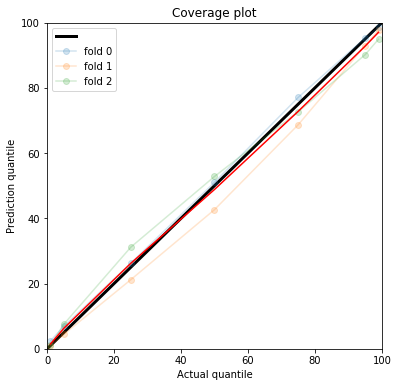

In [21]:
# Plot probability calibration plots
x = [1, 5, 25, 50, 75, 95, 99]
coverages = metrics.iloc[:-2,-7:]
plt.figure(figsize=(6, 6))
plt.plot([0] + x + [100], [0] + x + [100], 'k-', linewidth=3)
for coverage in coverages.values:
    plt.plot(x, coverage, 'o-', alpha=0.2)
plt.plot(x, np.mean(coverages, axis=0), 'r-')
plt.legend([''] + ['fold ' + str(s) for s in np.arange(n_folds)])
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('Coverage plot')
plt.xlabel('Actual quantile')
plt.ylabel('Prediction quantile')

This calibration plots looks awesome. The model was only training on around 75 percent of the available data per fold
and we still achieve good RMSE, MAPE, SMAPE, and coverage of the different percentiles.